References:
1: https://www.mdpi.com/2504-3900/2/6/238 , still air statistics

2: https://docs.lib.purdue.edu/cgi/viewcontent.cgi?article=1023&context=resec-isea , MATLAB optimized conditions

3: https://www.golf-simulators.com/physics.html , attempt at accurate simulation

1:
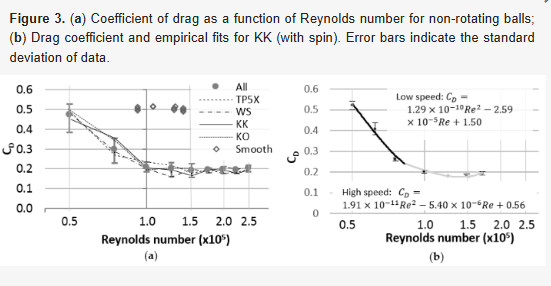

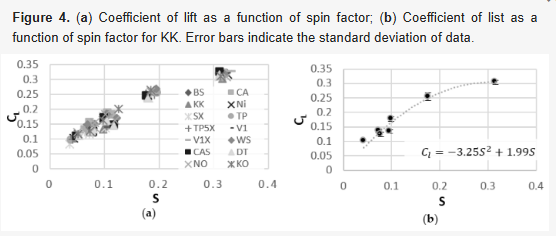

2:
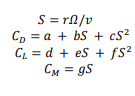

Spin factor =
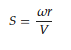

Where:

r=ball radius
omega=angularspeed
v=linearspeed


a=0.1304
b=0.9287
c=-0.8259
d=0.0504
e=1.2031
f=-1.1490
g=0.01

Wind force will be applied as a direct force vector instead of a fluid calculated using:

Defining the wind direction as measured by angle y use the following formulas to determine the x and z components of the wind force on the ball:

Fxw = Fw cos y = -cos y(Cdvw) 

Fzw = Fw cos y = -sin y (Cdvw) 

where vw = velocity of wind

General Formula:
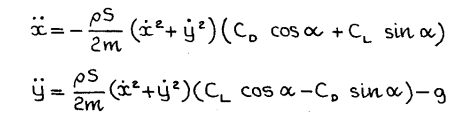

Where
p= air density
S= on stream surface
a = angle of incidence
g=gravity
dt=unit of time (0.01 or so?, depending on calculation time)

CONSIDER No z axis and instead transform x,y based on club head incidence angle

## FROM NASA General Ballistic Formula
### Terminal velocity
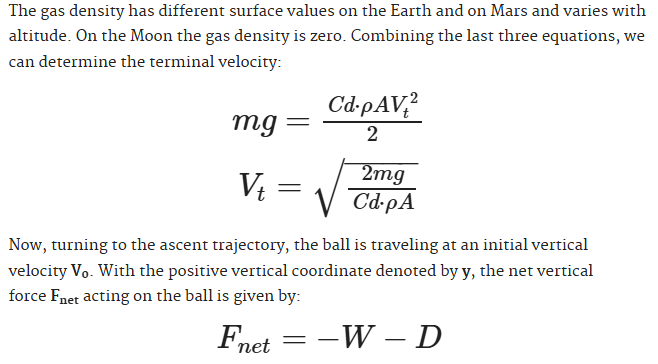

Cd= drag coefficient (determined using function of reynolds number)

Add Lift force to the ascending vertical velocity net force

### Solve for Air density
air density rho = 1.225 (1 - Ly/To)^gM/RL

M = molar mass of gas = 0.02896 kg/mol

L = temperature lapse rate = 0.0065 K/m

R = ideal gas constant 8.314 J/molK

To = temperature at sea level

po = 101325 pa

Temperature at height T=To - Ly

pressure = po * (1- Ly/To)^gM/RL

As a function of height y: rho = po * M / (R * To) * (1 - Ly/To)^(gM/RL-1)

## Ascent
### Net Forces
Fnet = ma = -W - D + L

ma= -mg - Cd*airdensity*CSArea*v^2/2 + Cl*airdensity*CSArea*v^2/2

diameter = 42.67 mm

CSArea = pi*(42.67/2)^2 = 0.0014301 m^2

mass = 0.04593 kg

gravity = 9.81 m/s^2

initial velocity = 0
### Solve for acceleration
a = -g - Cd*airdensity*CSArea*v^2/2m + Cl*airdensity*v^2*CSArea/2m

### Solve for velocity
vt = v(t-1) + a(t-1)*t

### Solve for position
yt = y(t-1) + vt

t = time interval

## Descent

### Net Forces
Fnet = -ma + D = 0
a = 0
V = Vterminal
Vterminal = sqrt(2mg/(Cd*rho*CSArea))

## Horizontal
Fnet = -D
a = -Cd * CSArea * rho * U^2 / (2m)

U = horizontal velocity (launch value)
u = Vt^2(Uo)/(Vt^2+g*Uo*t)
x = Vt^2/g * ln((V*t^2 + g*Uo*t)/Vt^2))

## Backspin

https://www.youtube.com/watch?v=auJPuzKigGA

Vx(t) = vx0 - m*g*friction*dt

Vw(t) = 2*math.pi*RPM/60 + m*g*friction/(2/5*m*radius**2) *dt

sphere beta = 2/5

a(w) = m*g*friction*radius/(0.4*m*radius**2)

friction force as a result of spin = -(coefficientoffriction)*m*g*sgn(vx-wx*radius)x

## Viscosity of air

https://doc.comsol.com/5.5/doc/com.comsol.help.cfd/cfd_ug_fluidflow_high_mach.08.27.html

sutherlands law

## Coefficient of restitution (bounce coefficient)

https://iopscience.iop.org/article/10.1088/1757-899X/36/1/012038/pdf

# Calculating

In [ ]:
#read launch conditions
v = read.Value(launchvelocity)
RPM = read.Value(rotationsperminute)
SS = read.Value(sidespin)
#positive value = clockwise spin, negative value = counterclockwise spin
theta = read.Value(launchangle)
#calculate ball flight values
vx = v*cos(theta)
vy = v*sin(theta)
molarmass = 0.02896
slpressure = 101325
lapserate = 0.0065
R = 8.314
g = 9.81
sltemp = read.Value(temperature.Kelvin())
x = readposition.ball(x)
y = readposition.ball(y)
viscosity = (sltemp/273)^1.5*((273+111)/(sltemp+111))
CSarea = 3.1415*(radius)^2
m = read.ball(mass)
S = 2*3.1415*RPM/60*radius/v

t = 0.01
p = slpressure * (1 - (lapserate*y)/sltemp)^(g*molarmass/(R*slpressure))
rho = slpressure * molarmass / (R*(sltemp+lapserate*y)) * (1-lapserate*y/(sltemp+lapserate*y))^(g*molarmass/(R*slpressure)-1)
Re = v * 0.04267 / viscosity
if Re < 7.5*10^4
    Cd = Cdlow
    else Cd = Cdhigh
Cdlow = 1.29*10^-10*Re^2-2.59*10^-5*Re+1.50
Cdhigh = 1.91*10^-11*Re^2-5.40*10^-6*Re+0.56
Cl = -3.25*S^2+1.99S
if vy != 0
    ay = -g-Cd*rho*CSarea*vy^2/(2*m)+Cl*rho*vy^2/(2*m)
    ax = -Cd*CSarea*rho*vx^2/(2*m)
    if vy <= 0
    ay = 0

# Classes

In [1]:
class Ball:
    def __init__(self, mass, radius,x,y,z):
        self.mass = mass
        self.radius = radius #m
        self.x = 0.0
        self.y = 0.0
        self.z = 0.0  # z is unused in 2D flight, but included per request

    def update_position(self, x, y, z):
        self.x = x
        self.y = y
        self.z = z

    def __str__(self):
        return (f"Ball(mass={self.mass}, radius={self.radius}, "
                f"x={self.x:.2f}, y={self.y:.2f}, z={self.z:.2f})")

In [2]:
class Player:
    def __init__(self, character_id, weight, height, gender):
        self.characterID = character_id
        self.weight = weight # in kg
        self.height = height  # in cm
        self.gender = gender     # string: 'male', 'female', 'other'
        self.launch_stats = {}   # dict to hold launch data like velocity, angle, RPM, etc.

    def record_launch(self, velocity, angle, rpm, sidespin, temperature_K):
        self.launch_stats = {
            'velocity': velocity,
            'angle': angle,
            'rpm': rpm,
            'sidespin': sidespin,
            'temperature_K': temperature_K
        }

    def __str__(self):
        return (f"Player({self.characterID}): {self.gender}, "
                f"{self.height} cm, {self.weight} kg\n"
                f"Launch Stats: {self.launch_stats}")

In [3]:
class Environment:
    def __init__(self, molar_mass, sl_pressure, temperature_C, terraintable):
        self.molar_mass = molar_mass
        self.sl_pressure = sl_pressure
        self.temperature_K = temprature_C + 273.15
        self.terrainmatrix = terraintable
        

In [4]:
standardball = Ball(mass=0.04593, radius=0.04267/2, x=0, y=0, z=0)
print(standardball.mass)

0.04593


In [5]:
Kevin = Player(character_id=0,weight=70,height=155,gender='M')
print(Kevin)

Player(0): M, 155 cm, 70 kg
Launch Stats: {}


In [158]:
Kevin.record_launch(70,14,10000,500,298)

In [159]:
print(Kevin)

Player(0): M, 155 cm, 70 kg
Launch Stats: {'velocity': 70, 'angle': 14, 'rpm': 10000, 'sidespin': 500, 'temperature_K': 298}


# Ball Flight Code

In [8]:
def sign(x):
    if x > 0:
        return 1
    elif x < 0:
        return -1
    else:
        return 0

# Good Stuff

In [165]:
import math

def simulate_ball_flight(player, ball,surface,friction, dt=0.01):
    # Unpack launch parameters from the Player
    v = player.launch_stats['velocity']
    angle_deg = player.launch_stats['angle']
    rpm = player.launch_stats['rpm']
    sidespin = player.launch_stats['sidespin']
    temp = player.launch_stats['temperature_K']

    # Unpack Ball parameters
    m = ball.mass
    radius = ball.radius

    # Initial position
    x = ball.x
    y = ball.y
    z = ball.z

    # Constants
    molar_mass = 0.02896 #Kg/mol
    sl_pressure = 101.325 #Kpa
    lapse_rate = 0.0065 #K/m
    R = 8.314 #J/mol*K
    g = 9.81 #m/s**2
    CS_area = math.pi * radius**2 #m^2
    
        # Coefficient of Restitution
    if surface == 'hard':
        CoR = 0.9
    else:
        CoR = 0.675

    vx = v * math.cos(math.radians(angle_deg))
    vy = v * math.sin(math.radians(angle_deg))
    vz = 0

    trajectory = []
    t = 0

    while vx > 0:
        altitude_factor = 1 - lapse_rate * y / temp

        p = sl_pressure * (altitude_factor)**(g * molar_mass / (R * lapse_rate))
        rho = sl_pressure * molar_mass / (R * temp) * (altitude_factor)**((g * molar_mass / (R * lapse_rate)) - 1)

        viscosity = (temp / 273)**1.5 * ((273 + 111) / (temp + 111))
        Re = v * 0.04267 / viscosity
        
        #Set boundary for low/high Re value
        if Re < 7.5e4:
            Cd = 1.29e-10 * Re**2 - 2.59e-5 * Re + 1.50
        else:
            Cd = 1.91e-11 * Re**2 - 5.40e-6 * Re + 0.56
        
        #Spin decay (4% per second)
        rpm *= 0.96 ** dt
        sidespin *= 0.96 ** dt

        #spin factor
        S = 2 * math.pi * rpm / 60 * radius / v
        Sz = 2 * math.pi * sidespin / 60 * radius / v
        Cl = -3.25 * S**2 + 1.99 * S
        Clz = -3.25 * Sz**2 + 1.99 * Sz

        #accelerations
        ax = -Cd * CS_area * rho * v**2/(2*m)
        az = Clz * rho * CS_area * v**2/(2*m)*(-sign(rpm)) - Cd * rho * CS_area * v**2/(2*m)
        if vy > 0:
            ay = -g - Cd * rho * CS_area * v**2/(2*m) + Cl *rho* CS_area *v**2/(2*m)
        else:
            ay = -9.81

        # Update velocity and position
        vx += ax * dt
        vy += ay * dt
        vz += az * dt
        v = math.sqrt(vx**2 + vy**2 + vz**2)
    
        x += vx * dt
        y += vy * dt
        z += vz * dt

        # Store: t, x, y,z, vx, vy,vz
        trajectory.append([round(t, 4), round(x, 4), round(y, 4), round(z, 4), round(vx, 4), round(vy, 4), round(vz, 4)])

        t += dt
        
                # Bounce logic
        if y <= 0 and vy < 0:
            bounce_apex = (vy**2) / (2 * g)
            #rolling logic

            if bounce_apex <= radius:
                vy = 0  # Ball stops bouncing

                # Calculate direction of friction based on whether or not angular velocity > linear velocity
                v_rel = vx - (rpm * 2 * math.pi/60) * radius  # rpm to rad/s * radius = tangential speed
                #Now sidespin
                v_rel_z = vz - (sidespin * 2 * math.pi/60)*radius

                # Apply spin-induced friction
                spin_friction_force = -friction * m * g * sign(v_rel)
                ax = spin_friction_force / m
                vx += ax * dt
                z_friction_force = -friction * m * g *sign(v_rel_z)
                az = z_friction_force / m
                vz += az * dt

                    #  if vx < 0:
                    #   vx += -radius*(2*math.pi*rpm/60 + (m*g*friction)/(2/5*m*radius**2)) *dt
            else:
                vy = -vy * CoR
                vx *= ((CoR + friction)/2)  # Optional: horizontal damping
                vz *= ((CoR + friction)/2)   # Optional: spin lift decay after bounce
                rpm *= ((CoR + friction)/2) 
                sidespin *= ((CoR + friction)/2)
                y = 0       # Reset to ground level

            # Stop if ball stops rolling
            if abs(vx) < 0.01 and abs(vz) < 0.01 and abs(az)<0.05 and abs(ax)<0.05:
                break
    return trajectory

In [96]:
import math

def simulate_ball_flight_new(player, ball,surface,friction, dt=0.01):
    player=player
    ball=ball
    surface=surface
    friction=friction
    # Unpack launch parameters from the Player
    v = player.launch_stats['velocity']
    angle_deg = player.launch_stats['angle']
    rpm = player.launch_stats['rpm']
    sidespin = player.launch_stats['sidespin']
    temp = player.launch_stats['temperature_K']

    # Unpack Ball parameters
    m = ball.mass
    radius = ball.radius

    # Initial position
    x = ball.x
    y = ball.y
    z = ball.z

    # Constants
    molar_mass = 0.02896 #Kg/mol
    sl_pressure = 101.325 #Kpa
    lapse_rate = 0.0065 #K/m
    R = 8.314 #J/mol*K
    g = 9.81 #m/s**2
    CS_area = math.pi * radius**2 #m^2
    
    # Coefficient of Restitution
    if surface == 'hard':
        CoR = 0.9
    else:
        CoR = 0.675

    vx = v * math.cos(math.radians(angle_deg))
    vy = v * math.sin(math.radians(angle_deg))
    vz = 0
    wx = (rpm * 2 * math.pi / 60) * radius
    wz = (sidespin * 2 * math.pi / 60) * radius

    newtrajectory = []
    t = 0

    while vx > 0:
        rolling = False
        altitude_factor = 1 - lapse_rate * y / temp

        p = sl_pressure * (altitude_factor)**(g * molar_mass / (R * lapse_rate))
        rho = sl_pressure * molar_mass / (R * temp) * (altitude_factor)**((g * molar_mass / (R * lapse_rate)) - 1)

        viscosity = (temp / 273)**1.5 * ((273 + 111) / (temp + 111))
        Re = v * 0.04267 / viscosity
        
        #Set boundary for low/high Re value
        if Re < 7.5e4:
            Cd = 1.29e-10 * Re**2 - 2.59e-5 * Re + 1.50
        else:
            Cd = 1.91e-11 * Re**2 - 5.40e-6 * Re + 0.56
        
        #Spin decay (4% per second)
        rpm *= 0.96 ** dt
        sidespin *= 0.96 ** dt

        #spin factor
        S = 2 * math.pi * rpm / 60 * radius / v
        Sz = 2 * math.pi * sidespin / 60 * radius / v
        Cl = -3.25 * S**2 + 1.99 * S
        Clz = -3.25 * Sz**2 + 1.99 * Sz

        if not rolling:
            # Flying phase
            ax = -Cd * CS_area * rho * v**2 / (2 * m)
            az = Clz * rho * CS_area * v**2 / (2 * m) * (-sign(rpm)) - Cd * rho * CS_area * v**2 / (2 * m)
            if vy > 0:
                ay = -g - Cd * rho * CS_area * v**2 / (2 * m) + Cl * rho * CS_area * v**2 / (2 * m)
            else:
                ay = -g
        else:
            # Rolling phase
            ay = -9.81
            ax = -friction * g * sign(vx)
            az = -friction * g * sign(vz)


        # Update velocity and position
        vx += ax * dt
        vy += ay * dt
        vz += az * dt
        v = math.sqrt(vx**2 + vy**2 + vz**2)

        x += vx * dt
        y += vy * dt
        z += vz * dt
        y = max(y, 0)  # Prevent sinking below ground due to float precision

        # Store trajectory
        newtrajectory.append([round(t, 4), round(x, 4), round(y, 4), round(z, 4), round(vx, 4), round(vy, 4), round(vz, 4)])
        t += dt

        # Bounce logic
        if y <= 0 and vy < 0:
            has_bounced = True
            bounce_apex = (vy**2) / (2 * g)

            if bounce_apex <= radius:
                vy = 0  # Ball stops bouncing
                rolling = True

                # ROLLING spin-fraction logic
                v_rel = vx - wx * radius
                v_rel_z = vz - wz * radius

                # Compute no-slip time
                # Using torque = I * alpha => alpha = torque / I
                I = (2/5) * m * radius**2
                alpha = friction * g / (radius * 0.4)  # angular acceleration
                tns_x = v_rel / (alpha * radius)
                tns_z = v_rel_z / (alpha * radius)

                # Simulate slip phase for t < tns
                slip_dt = min(dt, tns_x, tns_z)

                # Linear accelerations due to friction
                ax_friction = -friction * g * sign(v_rel)
                az_friction = -friction * g * sign(v_rel_z)

                # Angular accelerations
                alpha_x = friction * g / (0.4 * radius) * -sign(v_rel)
                alpha_z = friction * g / (0.4 * radius)*-sign(v_rel_z)

                # Update linear and angular velocities
                vx += ax_friction * slip_dt
                vz += az_friction * slip_dt
                wx += alpha_x * slip_dt
                wz += alpha_z * slip_dt

                # Clamp if signs reverse (no slip reached)
                if vx <= (wx*radius):
                    vx = wx * radius
                if vz <= (wz*radius):
                    vz = wz * radius

                # Update spin
                rpm = wx * 60 / (2 * math.pi)
                sidespin = wz * 60 / (2 * math.pi)
            else:
                vy = -vy * CoR
                vx *= (CoR + friction) / 2
                vz *= (CoR + friction) / 2
                rpm *= (CoR + friction) / 2
                sidespin *= (CoR + friction) / 2

                # Stop if ball stops rolling
                if abs(vx) < 0.05 and abs(vz) < 0.05 and abs(ax) < 0.1 and abs(az) < 0.1:
                    break


    return newtrajectory

In [169]:
trajectory = simulate_ball_flight(Kevin,standardball, 'soft', 0.3)
print(trajectory)

[[0, 0.6792, 0.1684, -0.0, 67.9193, 16.8354, -0.0014], [0.01, 1.3584, 0.3357, -0.0, 67.918, 16.7362, -0.0028], [0.02, 2.0375, 0.5021, -0.0001, 67.9166, 16.637, -0.0041], [0.03, 2.7167, 0.6675, -0.0001, 67.9153, 16.5378, -0.0055], [0.04, 3.3958, 0.8318, -0.0002, 67.9139, 16.4386, -0.0069], [0.05, 4.075, 0.9952, -0.0003, 67.9126, 16.3395, -0.0083], [0.06, 4.7541, 1.1576, -0.0004, 67.9112, 16.2403, -0.0097], [0.07, 5.4332, 1.3191, -0.0005, 67.9099, 16.1411, -0.011], [0.08, 6.1123, 1.4795, -0.0006, 67.9085, 16.0419, -0.0124], [0.09, 6.7913, 1.6389, -0.0008, 67.9072, 15.9428, -0.0138], [0.1, 7.4704, 1.7973, -0.0009, 67.9058, 15.8436, -0.0152], [0.11, 8.1494, 1.9548, -0.0011, 67.9045, 15.7444, -0.0165], [0.12, 8.8285, 2.1112, -0.0013, 67.9032, 15.6452, -0.0179], [0.13, 9.5075, 2.2667, -0.0014, 67.9018, 15.5461, -0.0193], [0.14, 10.1865, 2.4212, -0.0017, 67.9005, 15.4469, -0.0206], [0.15, 10.8655, 2.5746, -0.0019, 67.8991, 15.3477, -0.022], [0.16, 11.5445, 2.7271, -0.0021, 67.8978, 15.2486, -

In [161]:
newtrajectory = simulate_ball_flight_new(Kevin,standardball, 'soft', 0.9)

In [162]:
print(newtrajectory)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [14]:
import matplotlib.pyplot as plt

def plot_trajectory(trajectory):
    # Extract x and y positions from trajectory list
    x_vals = [point[4] for point in trajectory]
    y_vals = [point[0] for point in trajectory]

    plt.figure(figsize=(10, 6))
    plt.plot(x_vals, y_vals, label='Ball Flight Path')
    plt.xlabel('Velocity (m)')
    plt.ylabel('Time (s)')
    plt.title('Ball Trajectory')
    plt.grid(True)
    plt.legend()
    plt.show()

In [169]:
trajectory = simulate_ball_flight(Kevin,standardball,'soft',0.5)

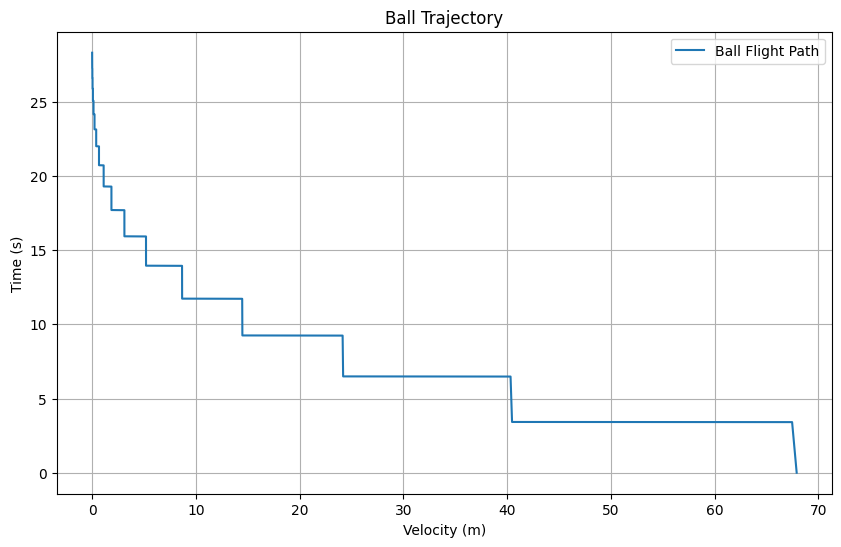

In [167]:
plot_trajectory(trajectory)

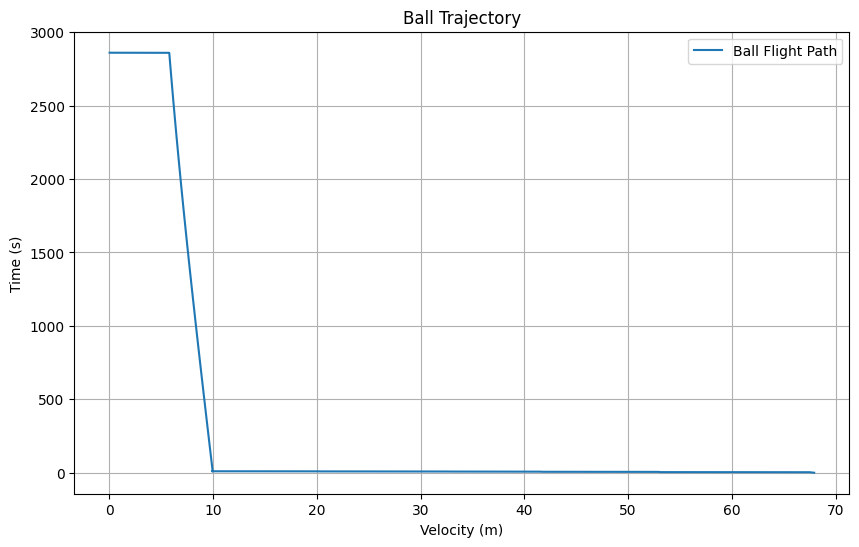

In [163]:
plot_trajectory(newtrajectory)

In [16]:
from mpl_toolkits.mplot3d import Axes3D

In [17]:
def plot_trajectory_3d(trajectory):
    x_vals = [row[1] for row in trajectory]
    y_vals = [row[2] for row in trajectory]
    z_vals = [row[3] for row in trajectory]

    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(x_vals, z_vals, y_vals, label='3D Ball Trajectory')
    ax.set_xlabel('x (m) - forward')
    ax.set_ylabel('z (m) - lateral')
    ax.set_zlabel('y (m) - vertical')
    ax.set_title('3D Ball Flight with Sidespin')
    ax.legend()
    plt.tight_layout()
    plt.show()

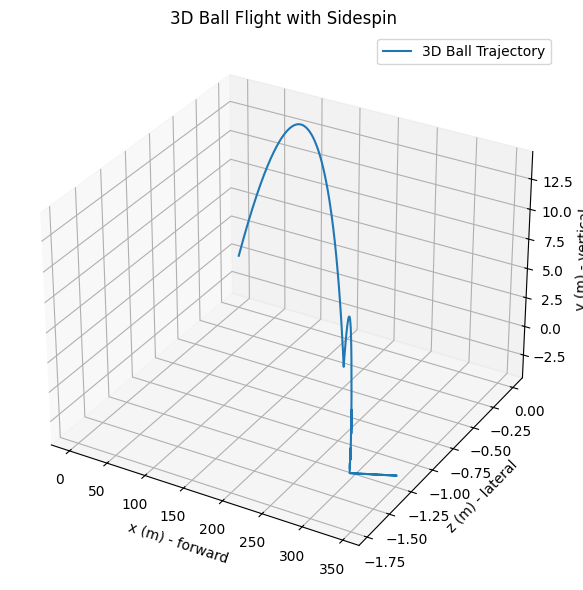

In [170]:
plot_trajectory_3d(trajectory)

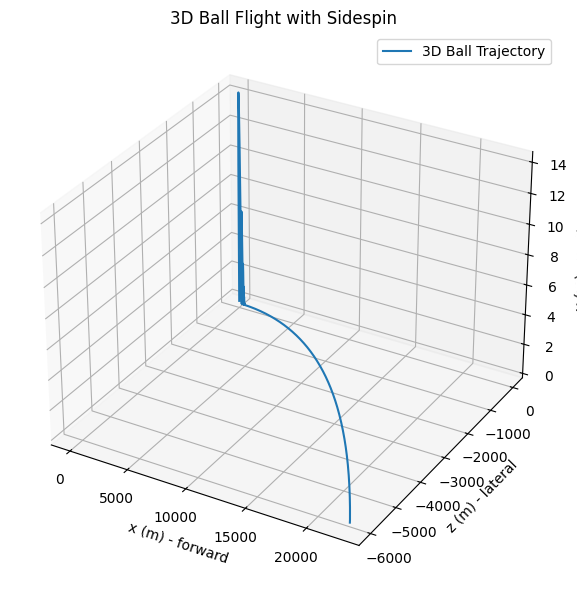

In [164]:
plot_trajectory_3d(newtrajectory)